C:\Users\jvgat\AppData\Local\Temp\ipykernel_12664\4038364862.py:8: DtypeWarning: Columns (34,35,36,37,39,40,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")


Cross-listing count distribution:
count    127515.000000
mean          1.445155
std           0.497048
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: cross_listing_count, dtype: float64

CWE risk factor distribution:
count    127515.000000
mean          0.005289
std           0.009339
min           0.000000
25%           0.000576
50%           0.001830
75%           0.008772
max           1.000000
Name: cwe_risk_factor, dtype: float64

New strata distribution:
cross_listing_count_cat  cwe_risk_category
1                        low                  25843
                         medium                9964
                         high                 17315
                         critical             17633
2                        low                  21075
                         medium                7120
                         high                 14927
                         critical             13634
3 

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a


Model Summary:
                                 coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                    
base_score                   0.441767   1.555453  0.028970        0.384987   
repo_publication_lag_rank   -0.000010   0.999990  0.000002       -0.000015   
cross_listing_variance_sqrt -0.116386   0.890132  0.092662       -0.298000   

                             coef upper 95%  exp(coef) lower 95%  \
covariate                                                          
base_score                         0.498547             1.469595   
repo_publication_lag_rank         -0.000006             0.999985   
cross_listing_variance_sqrt        0.065229             0.742301   

                             exp(coef) upper 95%  cmp to          z  \
covariate                                                             
base_score                              1.646328     0.0  15.249110   
repo_publication_lag_rank              

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2744: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, _df in self._predicted_partial_hazards_.groupby(self.strata):



Concordance index: 0.6837224171128504


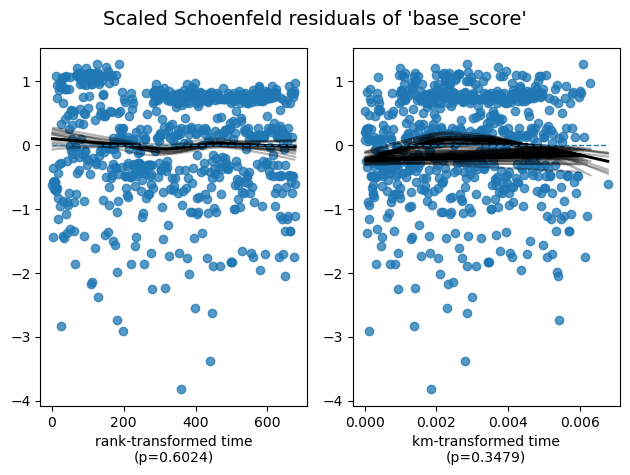

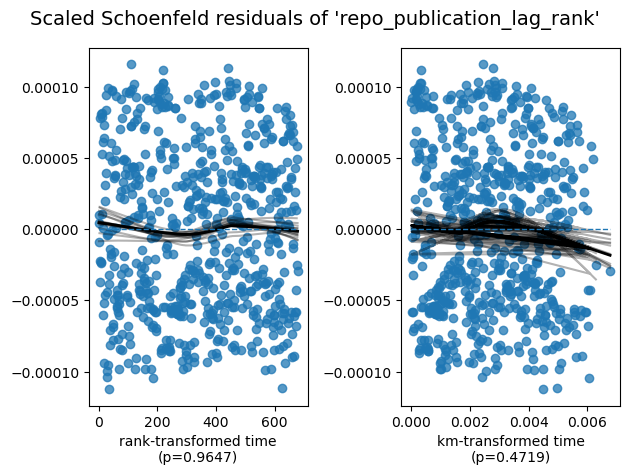

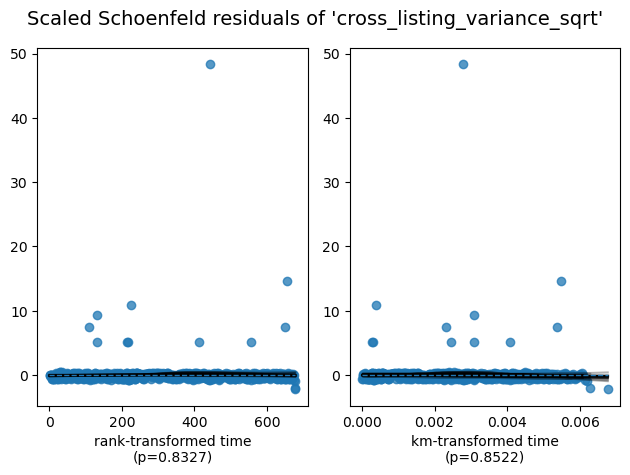

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")
date_cols = ['published_date','kev_published']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

df['time_to_event'] = (df['kev_published'] - df['published_date']).dt.total_seconds() / (60*60*24)
df['event'] = df['kev_present']
df.loc[df['event'] == 0, 'time_to_event'] = (pd.Timestamp.now(tz='UTC') - df.loc[df['event'] == 0, 'published_date']).dt.total_seconds() / (60*60*24)

features = ['base_score', 'repo_publication_lag', 'cross_listing_count','cross_listing_variance', 'cwe_risk_factor']
df_model = df[features + ['time_to_event', 'event']].dropna().copy()

# Apply transformations
df_model['repo_publication_lag_rank'] = df_model['repo_publication_lag'].rank()
df_model['cross_listing_variance_sqrt'] = np.sqrt(df_model['cross_listing_variance'])

# FIXED: Better categorization based on actual data distribution
print("Cross-listing count distribution:")
print(df_model['cross_listing_count'].describe())
print("\nCWE risk factor distribution:")
print(df_model['cwe_risk_factor'].describe())

# Create categories that actually have data
df_model['cross_listing_count_cat'] = pd.cut(
    df_model['cross_listing_count'], 
    bins=[0, 1, 2, float('inf')],  # Adjusted bins
    labels=['1', '2', '3']
)

df_model['cwe_risk_category'] = pd.qcut(
    df_model['cwe_risk_factor'], 
    q=4,  # Reduced to 3 categories
    labels=['low', 'medium', 'high','critical'],
    duplicates='drop'
)

# Verify the new distribution
print("\nNew strata distribution:")
strata_counts = df_model.groupby(['cross_listing_count_cat', 'cwe_risk_category'], observed=True).size()
print(strata_counts)
print(f"\nNumber of valid strata: {len(strata_counts[strata_counts > 0])}")

# Define transformed features and columns to include
transformed_features = ['base_score', 'repo_publication_lag_rank', 
                       'cross_listing_variance_sqrt']

model_cols = transformed_features + ['time_to_event', 'event', 
                                     'cross_listing_count_cat', 'cwe_risk_category']

df_final = df_model[model_cols].copy()

# Fit model with fixed stratification
cph = CoxPHFitter()
cph.fit(df_final, 
        duration_col='time_to_event', 
        event_col='event',
        strata=['cross_listing_count_cat', 'cwe_risk_category'])

print("\n" + "="*50)
print("Model Summary:")
print("="*50)
print(cph.summary)

# Check assumptions
cph.check_assumptions(df_final, 
                      columns=transformed_features, 
                      p_value_threshold=0.05, 
                      show_plots=True)

print(f"\nConcordance index: {cph.concordance_index_}")

In [2]:
df_final[df_final['event'] == 0].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()

C:\Users\jvgat\AppData\Local\Temp\ipykernel_12664\3849108951.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final[df_final['event'] == 0].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()


cross_listing_count_cat  cwe_risk_category
1                        low                  25842
                         medium                9964
                         high                 17315
                         critical             17632
2                        low                  21062
                         medium                7095
                         high                 14779
                         critical             13144
3                        low                      1
                         medium                   0
                         high                     1
                         critical                 2
dtype: int64

In [3]:
df_final[df_final['event'] == 1].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()

C:\Users\jvgat\AppData\Local\Temp\ipykernel_12664\2390181220.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final[df_final['event'] == 1].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()


cross_listing_count_cat  cwe_risk_category
1                        low                    1
                         medium                 0
                         high                   0
                         critical               1
2                        low                   13
                         medium                25
                         high                 148
                         critical             490
3                        low                    0
                         medium                 0
                         high                   0
                         critical               0
dtype: int64

## Medium Analysis

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

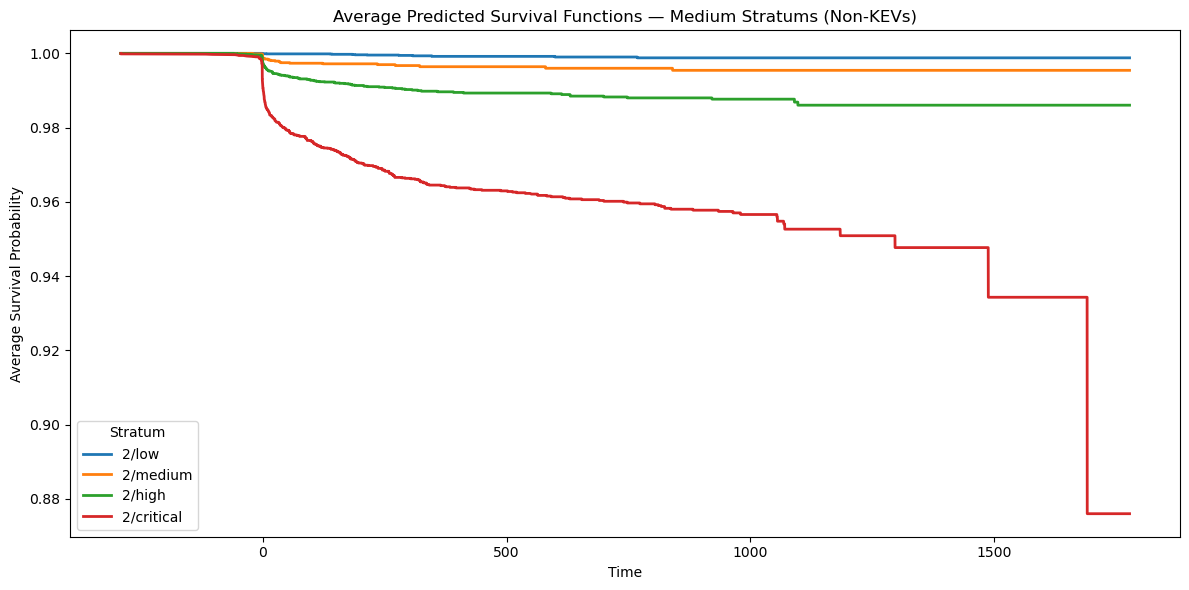

In [4]:
# ------------------------------
# 1) Keep only non-KEVs
# ------------------------------
df_nonkev = df_final[df_final['event'] == 0].copy()

# ------------------------------
# 2) Compute partial hazard for non-KEVs
# ------------------------------
df_nonkev['risk_score'] = cph.predict_partial_hazard(df_nonkev)

# ------------------------------
# 3) Merge metadata
# ------------------------------
df_nonkev = df_nonkev.merge(
    df[['vendorProject', 'product', 'vulnerabilityName']],
    left_index=True,
    right_index=True,
    how='left'
)

# ------------------------------
# 4) Create stratum column
# ------------------------------
df_nonkev['stratum'] = (
    df_nonkev['cross_listing_count_cat'].astype(str) + '/' +
    df_nonkev['cwe_risk_category'].astype(str)
)

# ------------------------------
# 5) Focus on selected strata
# ------------------------------
strata_focus = ['2/low', '2/medium', '2/high', '2/critical']
df_focus = df_nonkev[df_nonkev['stratum'].isin(strata_focus)]

# ------------------------------
# 6) Average survival curves per stratum
# ------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    
    if df_stratum.empty:
        continue
    
    # Predict survival functions for all rows in this stratum
    surv_funcs = cph.predict_survival_function(df_stratum)
    
    # Compute average survival at each time point
    avg_surv = surv_funcs.mean(axis=1)
    
    ax.plot(avg_surv.index, avg_surv.values, label=stratum, linewidth=2)

ax.set_title("Average Predicted Survival Functions — Medium Stratums (Non-KEVs)")
ax.set_xlabel("Time")
ax.set_ylabel("Average Survival Probability")
ax.legend(title="Stratum")
plt.tight_layout()
plt.show()

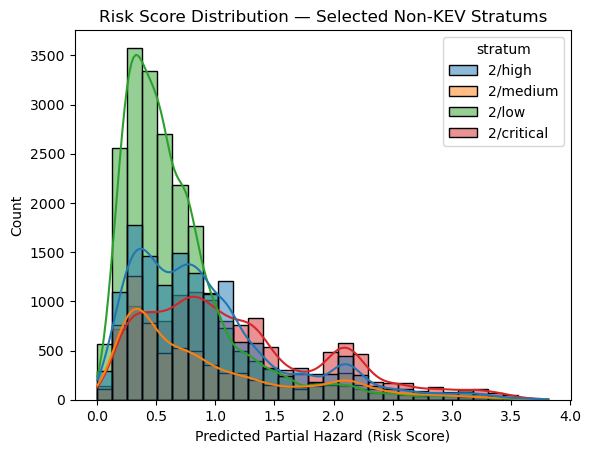

In [5]:
sns.histplot(df_focus, x='risk_score', hue='stratum', kde=True, bins=30)
plt.title("Risk Score Distribution — Selected Non-KEV Stratums")
plt.xlabel("Predicted Partial Hazard (Risk Score)")
plt.ylabel("Count")
plt.show()

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

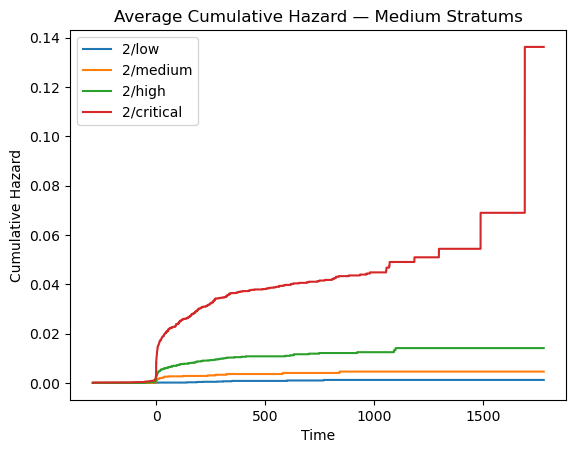

In [6]:
for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    cumhaz = cph.predict_cumulative_hazard(df_stratum).mean(axis=1)
    plt.plot(cumhaz.index, cumhaz.values, label=stratum)

plt.title("Average Cumulative Hazard — Medium Stratums")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.legend()
plt.show()


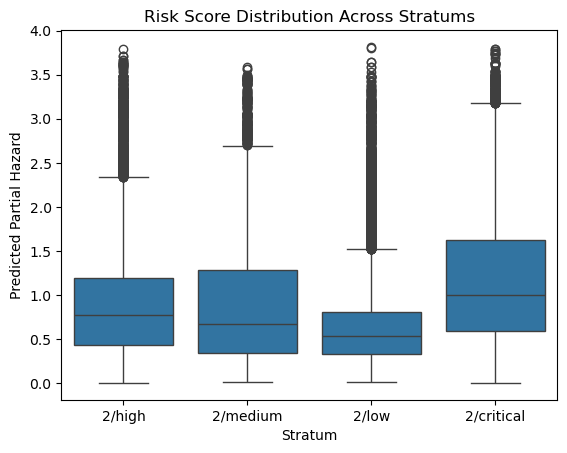

In [7]:
sns.boxplot(data=df_focus, x='stratum', y='risk_score')
plt.title("Risk Score Distribution Across Stratums")
plt.xlabel("Stratum")
plt.ylabel("Predicted Partial Hazard")
plt.show()

## Low Analysis

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

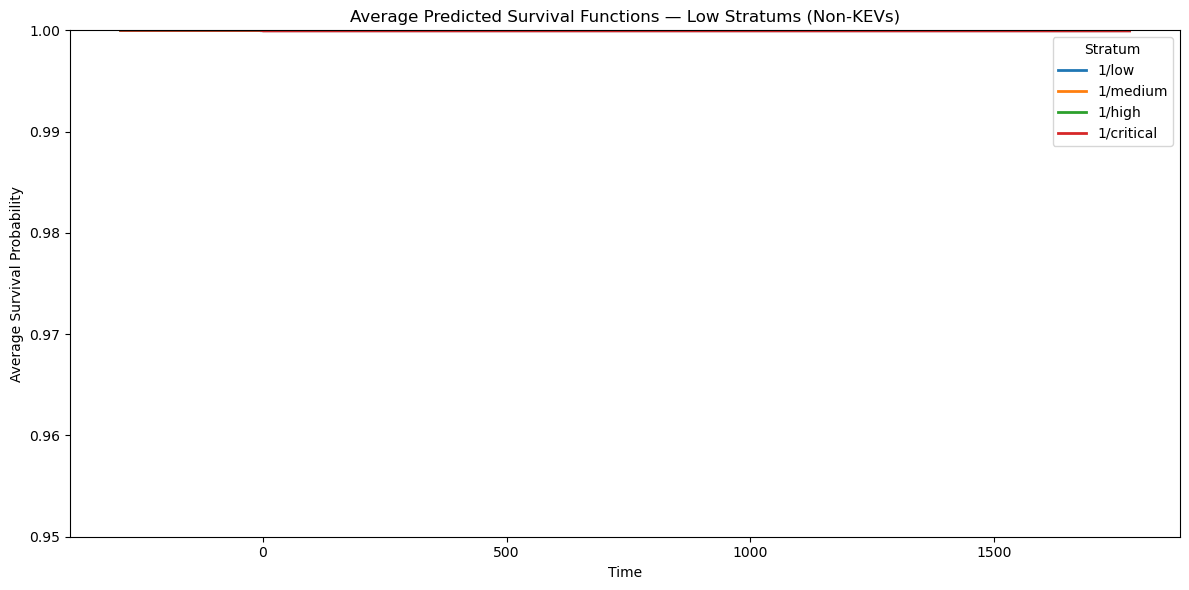

In [8]:
# ------------------------------
# 1) Keep only non-KEVs
# ------------------------------
df_nonkev = df_final[df_final['event'] == 0].copy()

# ------------------------------
# 2) Compute partial hazard for non-KEVs
# ------------------------------
df_nonkev['risk_score'] = cph.predict_partial_hazard(df_nonkev)

# ------------------------------
# 3) Merge metadata
# ------------------------------
df_nonkev = df_nonkev.merge(
    df[['vendorProject', 'product', 'vulnerabilityName']],
    left_index=True,
    right_index=True,
    how='left'
)

# ------------------------------
# 4) Create stratum column
# ------------------------------
df_nonkev['stratum'] = (
    df_nonkev['cross_listing_count_cat'].astype(str) + '/' +
    df_nonkev['cwe_risk_category'].astype(str)
)

# ------------------------------
# 5) Focus on selected strata
# ------------------------------
strata_focus = ['1/low', '1/medium', '1/high', '1/critical']
df_focus = df_nonkev[df_nonkev['stratum'].isin(strata_focus)]

# ------------------------------
# 6) Average survival curves per stratum
# ------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    
    if df_stratum.empty:
        continue
    
    # Predict survival functions for all rows in this stratum
    surv_funcs = cph.predict_survival_function(df_stratum)
    
    # Compute average survival at each time point
    avg_surv = surv_funcs.mean(axis=1)
    
    ax.plot(avg_surv.index, avg_surv.values, label=stratum, linewidth=2)

ax.set_title("Average Predicted Survival Functions — Low Stratums (Non-KEVs)")
ax.set_xlabel("Time")
ax.set_ylabel("Average Survival Probability")
ax.legend(title="Stratum")
ax.set_ylim(0.95, 1.00)
plt.tight_layout()
plt.show()

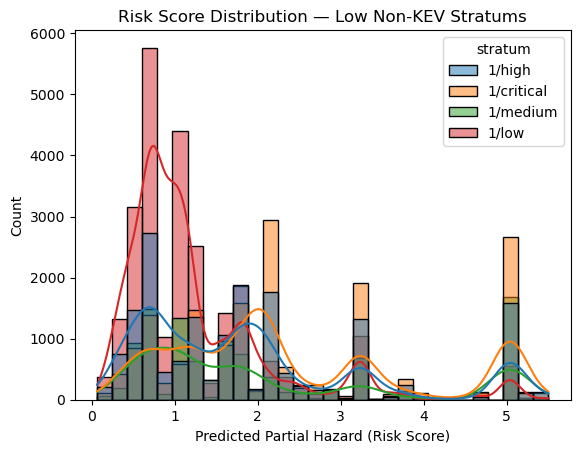

In [9]:
import seaborn as sns
sns.histplot(df_focus, x='risk_score', hue='stratum', kde=True, bins=30)
plt.title("Risk Score Distribution — Low Non-KEV Stratums")
plt.xlabel("Predicted Partial Hazard (Risk Score)")
plt.ylabel("Count")
plt.show()

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

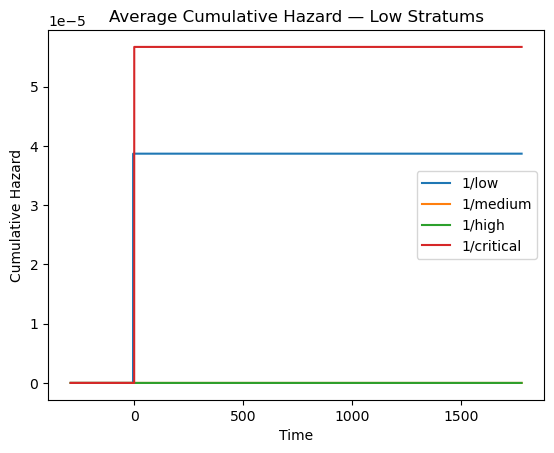

In [10]:
for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    cumhaz = cph.predict_cumulative_hazard(df_stratum).mean(axis=1)
    plt.plot(cumhaz.index, cumhaz.values, label=stratum)

plt.title("Average Cumulative Hazard — Low Stratums")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
ax.set_ylim(0.00, 0.05)
plt.legend()
plt.show()

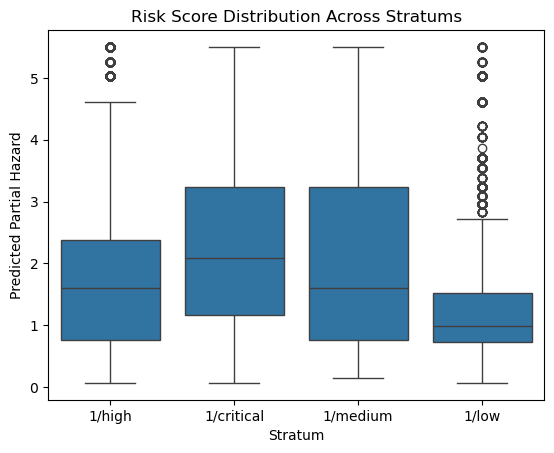

In [11]:
sns.boxplot(data=df_focus, x='stratum', y='risk_score')
plt.title("Risk Score Distribution Across Stratums")
plt.xlabel("Stratum")
plt.ylabel("Predicted Partial Hazard")
plt.show()

## Merged Analysis


C:\Users\jvgat\AppData\Local\Temp\ipykernel_12664\2318709958.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_nonkev['cross_listing_count_cat_merged'] = df_nonkev['cross_listing_count_cat'].replace({
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):



Valid strata included in plot: ['1-2/low', '1-2/medium', '1-2/high', '1-2/critical']


c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

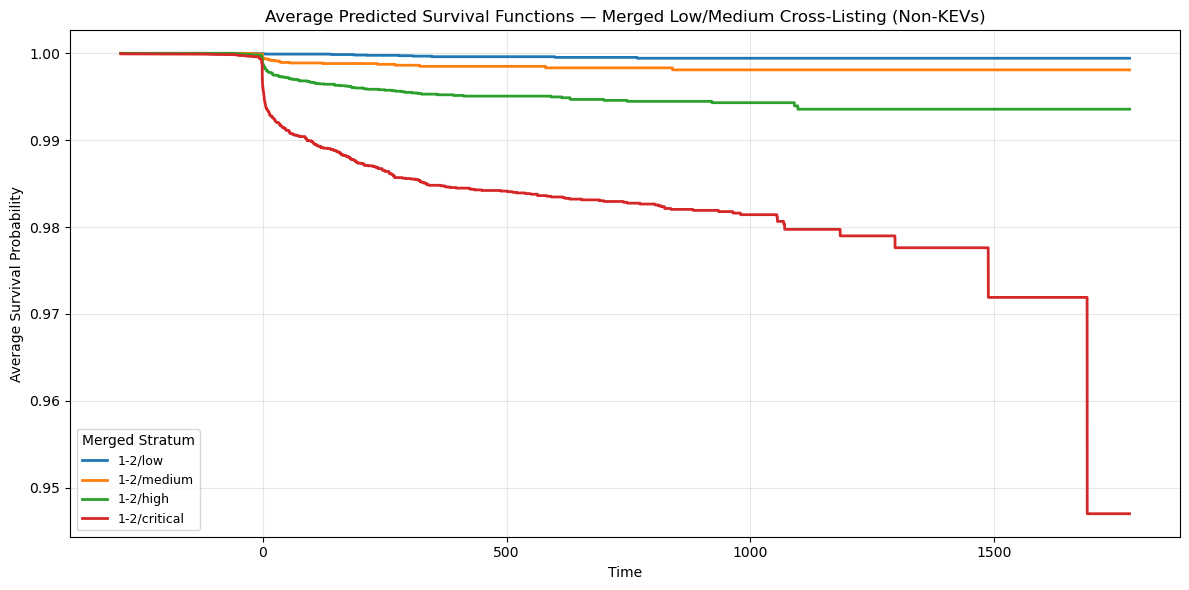

In [12]:
# -------------------------------------------------
# 1) Keep only non-KEVs
# -------------------------------------------------
df_nonkev = df_final[df_final['event'] == 0].copy()

# -------------------------------------------------
# 2) Compute partial hazard for non-KEVs
# -------------------------------------------------
df_nonkev['risk_score'] = cph.predict_partial_hazard(df_nonkev)

# -------------------------------------------------
# 3) Merge metadata (optional if needed later)
# -------------------------------------------------
df_nonkev = df_nonkev.merge(
    df[['vendorProject', 'product', 'vulnerabilityName']],
    left_index=True,
    right_index=True,
    how='left'
)

# -------------------------------------------------
# 4) Merge low-sample strata (1 and 2 → "1-2")
# -------------------------------------------------
df_nonkev['cross_listing_count_cat_merged'] = df_nonkev['cross_listing_count_cat'].replace({
    '1': '1-2',
    '2': '1-2',
    '3': '3+'
})

# -------------------------------------------------
# 5) Create merged stratum label
# -------------------------------------------------
df_nonkev['stratum'] = (
    df_nonkev['cross_listing_count_cat_merged'].astype(str) + '/' +
    df_nonkev['cwe_risk_category'].astype(str)
)

# -------------------------------------------------
# 6) Focus on selected merged strata
# -------------------------------------------------
strata_focus = ['1-2/low', '1-2/medium', '1-2/high', '1-2/critical']
df_focus = df_nonkev[df_nonkev['stratum'].isin(strata_focus)]

# Skip very small groups
valid_strata = [
    s for s in strata_focus if (df_focus['stratum'] == s).sum() > 10
]
print("\nValid strata included in plot:", valid_strata)

# -------------------------------------------------
# 7) Plot average survival curves for merged strata
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

for stratum in valid_strata:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    if df_stratum.empty:
        continue

    # Predict survival functions for this stratum
    surv_funcs = cph.predict_survival_function(df_stratum)

    # Compute average survival at each time point
    avg_surv = surv_funcs.mean(axis=1)

    ax.plot(avg_surv.index, avg_surv.values, label=stratum, linewidth=2)

# -------------------------------------------------
# 8) Format and display
# -------------------------------------------------
ax.set_title("Average Predicted Survival Functions — Merged Low/Medium Cross-Listing (Non-KEVs)", fontsize=12)
ax.set_xlabel("Time")
ax.set_ylabel("Average Survival Probability")
ax.legend(title="Merged Stratum", fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


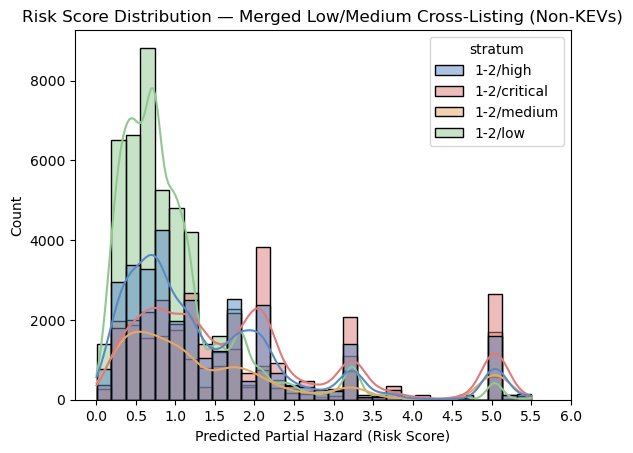

In [13]:
# Define custom colors for each stratum
custom_palette = {
    '1-2/high': '#5A8AC6',      # Blue (matching left plot)
    '1-2/critical': '#E07A7A',  # Red (matching left plot)
    '1-2/medium': '#E8A864',    # Orange (matching left plot)
    '1-2/low': '#90C890'        # Green (matching left plot)
}

sns.histplot(
    df_focus,
    x='risk_score',
    hue='stratum',
    kde=True,
    bins=30,
    palette=custom_palette
)

plt.title("Risk Score Distribution — Merged Low/Medium Cross-Listing (Non-KEVs)")
plt.xlabel("Predicted Partial Hazard (Risk Score)")
plt.ylabel("Count")
plt.xticks(np.arange(0, df_focus['risk_score'].max() + 0.5, 0.5))
plt.show()


c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

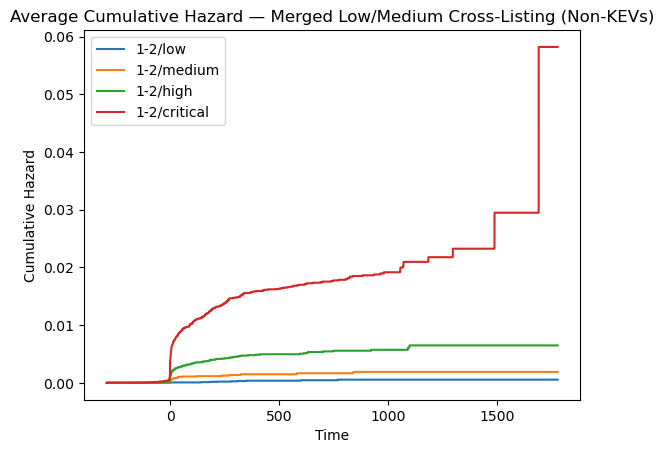

In [14]:
for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    cumhaz = cph.predict_cumulative_hazard(df_stratum).mean(axis=1)
    plt.plot(cumhaz.index, cumhaz.values, label=stratum)

plt.title("Average Cumulative Hazard — Merged Low/Medium Cross-Listing (Non-KEVs)")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.legend()
plt.show()


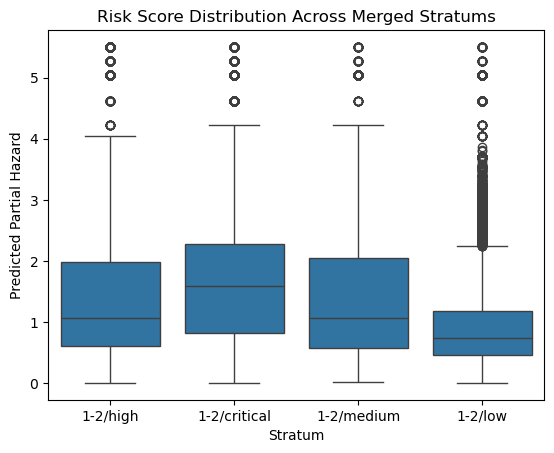

In [15]:
sns.boxplot(data=df_focus, x='stratum', y='risk_score')
plt.title("Risk Score Distribution Across Merged Stratums")
plt.xlabel("Stratum")
plt.ylabel("Predicted Partial Hazard")
plt.show()